## Metagene profiles: ORF vs TIF annotations

In [1]:
import itertools
import sys
import numpy as np
import pandas as pd
import os
import collections
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns

In [2]:
home_dir = '/home/salma/Coding/scratch/'

pipeline_dir = os.path.join(home_dir, 'pipeline')
plotting_dir = os.path.join(home_dir, 'plots/metagene_TIF_CDS')

In [3]:
#load data list
pathways_of_interest =['NMD', 'Deadenylation', 'Decapping', 'TRAMP', 'Ski', 'Exosome', 'Xrn1']
data_summary = pd.read_table(os.path.join(home_dir, 'data_summary_detailed.txt'), header=None)
data_summary.columns=['factor','pathway','group']
factors = data_summary.loc[data_summary.pathway.isin(pathways_of_interest), 'factor']

In [4]:
direc_names  = [d for d in os.listdir(pipeline_dir) if os.path.isdir(os.path.join(pipeline_dir, d))]

TIF_filename_5 = 'non_overlapping_TSS/TIF_NoOv_sense_TSS_centerBoth_up1000_gene750_do1000_min1000_max5000_sense.table'
TIF_filename_3 = 'non_overlapping_pA/TIF_NoOv_sense_pA_centerBoth_up1000_gene750_do1000_min1000_max5000_sense.table'

ORF_filename_5 = 'non_overlapping_TSS/CDS_NoOv_sense_TSS_centerBoth_up1000_gene750_do1000_min1000_max5000_sense.table'
ORF_filename_3 = 'non_overlapping_pA/CDS_NoOv_sense_pA_centerBoth_up1000_gene750_do1000_min1000_max5000_sense.table'

TIF_bs_5 = 'non_overlapping_TSS/TIF_NoOv_sense_TSS_centerBoth_up1000_gene750_do1000_min1000_max5000_sense_bs.table'
TIF_bs_3 = 'non_overlapping_pA/TIF_NoOv_sense_pA_centerBoth_up1000_gene750_do1000_min1000_max5000_sense_bs.table'

ORF_bs_5 = 'non_overlapping_TSS/CDS_NoOv_sense_TSS_centerBoth_up1000_gene750_do1000_min1000_max5000_sense_bs.table'
ORF_bs_3 = 'non_overlapping_pA/CDS_NoOv_sense_pA_centerBoth_up1000_gene750_do1000_min1000_max5000_sense_bs.table'

def read_metagene_profile(profile_filename):
    profiles = list()

    for d in factors:
        try:
            with open(glob.glob(os.path.join(pipeline_dir,d,'postprocess',profile_filename))[0]) as f:
                profiles.append([float(i) for i in f.readlines()[0].split()])
                f.close()
        except:
            print('could not read:' + d)
    profiles= pd.DataFrame(profiles, index=factors)        
    profiles.index = [s.split('_')[0] for s in profiles.index]
    profiles.index = [s.split('-')[0] for s in profiles.index]
    
    return profiles

def read_metagene_bs(profile_filename):
    profiles_low = list()
    profiles_high = list()

    for d in factors:
        x = pd.read_table(os.path.join(pipeline_dir,d,'postprocess',profile_filename), header=None)
        profiles_low.append(list(x.quantile(0.025, axis=0)))
        profiles_high.append(list(x.quantile(0.975, axis=0)))
        
    profiles_low= pd.DataFrame(profiles_low, index=factors)  
    profiles_high= pd.DataFrame(profiles_high, index=factors)
    profiles_low.index = [s.split('-')[0] for s in profiles_low.index]
    profiles_high.index = [s.split('-')[0] for s in profiles_high.index]
    
    return profiles_low, profiles_high

profiles_TIF5 = read_metagene_profile(TIF_filename_5)
profiles_TIF3 = read_metagene_profile(TIF_filename_3)
profiles_ORF5 = read_metagene_profile(ORF_filename_5)
profiles_ORF3 = read_metagene_profile(ORF_filename_3)

profiles_TIF_low5, profiles_TIF_high5 = read_metagene_bs(TIF_bs_5)
profiles_TIF_low3, profiles_TIF_high3 = read_metagene_bs(TIF_bs_3)

profiles_ORF_low5, profiles_ORF_high5 = read_metagene_bs(ORF_bs_5)
profiles_ORF_low3, profiles_ORF_high3 = read_metagene_bs(ORF_bs_3)

In [5]:
def plot_profile(pathway='NMD', col = ['darkblue', 'green']):
    
    factors = data_summary.loc[data_summary.pathway == pathway, 'factor']
    f,axes = plt.subplots(len(factors),2 ,sharey='row',sharex='col', figsize=(3.5,1.5*(len(factors))))
    plt.subplots_adjust(hspace = 0.0, wspace=0.04)
    
    
    
    for i, f in enumerate(factors):

        tif_5 = profiles_TIF5.loc[f,:]
        tif_3 = profiles_TIF3.loc[f,:]
        tif5 = tif_5[vlinepos[1]-interval:vlinepos[1]+interval]
        tif3 = tif_3[vlinepos[3]-interval:vlinepos[3]+interval] 
        
        orf_5 = profiles_ORF5.loc[f,:]
        orf_3 = profiles_ORF3.loc[f,:]
        
        orf5 = orf_5[vlinepos[1]-interval:vlinepos[1]+interval]
        orf3 = orf_3[vlinepos[3]-interval:vlinepos[3]+interval]
        

        x5 = np.arange(vlinepos[1]-interval,vlinepos[1]+interval,1)
        x3 = np.arange(vlinepos[3]-interval,vlinepos[3]+interval,1)

        if len(factors)==1:
            ax1 = axes[0]
            ax2 = axes[1]
        else:
            ax1 = axes[i][0]
            ax2 = axes[i][1]
        
        kw = dict(linewidth=1.2)
        
        alpha=0.2
        sl = ax1.plot(x5, tif5, color = col[1], label='TIF annotation', **kw, zorder=10)
        ul = ax1.plot(x5, orf5, color = col[0], ls='-', label='ORF annotation', **kw, zorder=9)
        ax1.fill_between(x5, profiles_TIF_low5.loc[f,:][vlinepos[1]-interval:vlinepos[1]+interval], 
                         profiles_TIF_high5.loc[f,:][vlinepos[1]-interval:vlinepos[1]+interval], facecolor=col[1], interpolate=True, alpha=alpha, zorder=5)
        ax1.fill_between(x5, profiles_ORF_low5.loc[f,:][vlinepos[1]-interval:vlinepos[1]+interval], 
                         profiles_ORF_high5.loc[f,:][vlinepos[1]-interval:vlinepos[1]+interval], facecolor=col[0], interpolate=True, alpha=alpha, zorder=6)
        
        ax2.plot(x3, tif3, color = col[1], label='TIF annotation', **kw, zorder=10)
        ax2.plot(x3, orf3, color = col[0], ls='-', label='ORF annotation', **kw, zorder=9)       
        ax2.fill_between(x3, profiles_TIF_low3.loc[f,:][vlinepos[3]-interval:vlinepos[3]+interval], 
                         profiles_TIF_high3.loc[f,:][vlinepos[3]-interval:vlinepos[3]+interval], facecolor=col[1], interpolate=True, alpha=alpha, zorder=5)
        ax2.fill_between(x3, profiles_ORF_low3.loc[f,:][vlinepos[3]-interval:vlinepos[3]+interval], 
                         profiles_ORF_high3.loc[f,:][vlinepos[3]-interval:vlinepos[3]+interval], facecolor=col[0], interpolate=True, alpha=alpha, zorder=6)

        ax1.set_xlim(vlinepos[1]-interval,vlinepos[1]+interval)
        ax2.set_xlim(vlinepos[3]-interval,vlinepos[3]+interval)

        ax1.set_xticks([vlinepos[1] - tick, vlinepos[1], vlinepos[1] + tick])
        ax2.set_xticks([vlinepos[3] - tick, vlinepos[3], vlinepos[3] + tick])

        ax1.set_xticklabels(['-'+str(tick), labels[1], '+'+str(tick)])
        ax2.set_xticklabels(['-'+str(tick), labels[3], '+'+str(tick)])
        
        if i is 0:
            ax1.tick_params(top=True, labeltop=True)
            ax2.tick_params(top=True, labeltop=True)

        # hide the spines between ax1 and ax2
        ax1.spines['right'].set_linestyle((0,(4,6)))
        ax1.spines['right'].set_color('grey')
        
        ax2.spines['left' ].set_linestyle((0,(4,6)))
        ax2.spines['left' ].set_color('grey')
               
        ax1.tick_params(labelright='off')
        ax1.tick_params(labelleft='off')
        ax2.tick_params(labelright='off')
        ax2.tick_params(labelleft='off')
        

        d = .03 # how big to make the diagonal lines in axes coordinates
        # arguments to pass plot, just so we don't keep repeating them
        kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False, linewidth=0.8)
        ax1.plot((1-d,1+d), (-d,+d), **kwargs)
        ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)
        
        kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
        ax2.plot((-d,+d), (1-d,1+d), **kwargs)
        ax2.plot((-d,+d), (-d,+d), **kwargs)

        ax1.axvline(x=vlinepos[1], color = 'grey', linewidth = 0.8, ls = (0,(3,3)))
        ax2.axvline(x=vlinepos[3], color = 'grey', linewidth = 0.8, ls = (0,(3,3)))
        
        ax1.set_ylabel(f, fontsize=13)
        ax1.set_yticks([], [])
        ax2.set_yticks([], [])
        ax1.get_yaxis().set_label_coords(-0.1,0.5)
        ax1.tick_params(labelsize = 8)
        ax1.xaxis.set_tick_params(labelsize=8)
        ax2.xaxis.set_tick_params(labelsize=8)
        #ax1.spines['top'].set_visible(False)
        ax1.spines['bottom'].set_visible(True)
        ax1.spines['left'].set_visible(False)
        #ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)

        ax1.set_ylim(0, 1.2*(ax1.get_ylim()[1]))
        if i==0:
            lgd = ax2.legend(bbox_to_anchor=(1.2,1.8), frameon=False)
    plt.savefig(os.path.join(plotting_dir, pathway + '_orf_tif_profiles.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    #plt.close()

In [6]:
sns.set_style('ticks')
print(plotting_dir)

/home/salma/Coding/scratch/plots/metagene_TIF_CDS


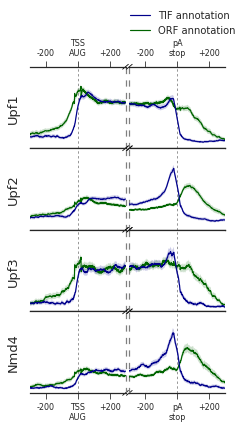

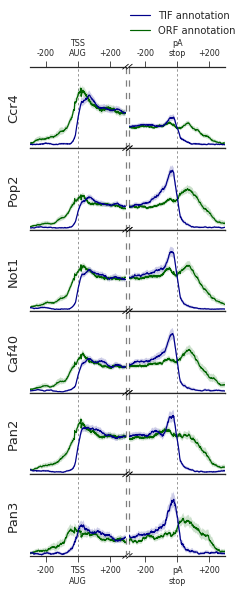

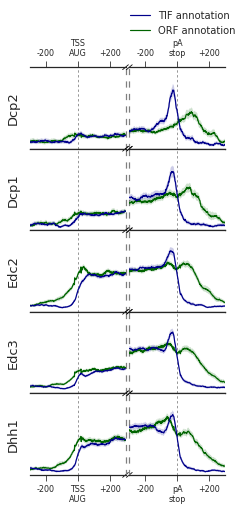

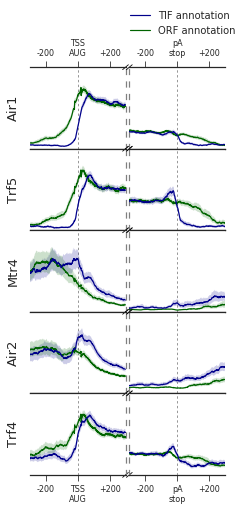

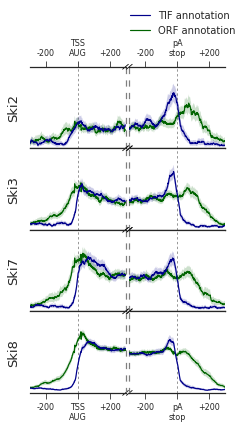

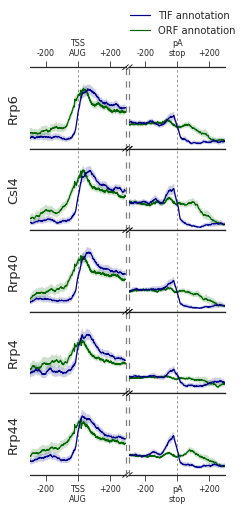

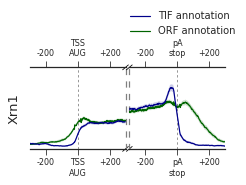

In [7]:
vlinepos = [1, 1000, 1751, 2501, 3499]
labels = ['-1000', 'TSS\nAUG', 'Gene Body', 'pA\nstop', '+1000']
interval = 300
tick = 200
for pathway in pathways_of_interest:
    plot_profile(pathway=pathway, col = ['darkgreen', 'darkblue'])

## metagene profiles on snoRNAs

In [8]:
home_dir = '/home/salma/Coding/scratch/'

pipeline_dir = os.path.join(home_dir, 'pipeline')
plotting_dir = os.path.join(home_dir, 'plots/metagene_ncRNAs')

In [9]:
#load data list
pathways_of_interest =['NMD', 'Deadenylation', 'Decapping', 'TRAMP', 'Ski', 'Exosome', 'Xrn1']
data_summary = pd.read_table(os.path.join(home_dir, 'data_summary_detailed.txt'), header=None)
data_summary.columns=['factor','pathway','group']
factors = data_summary.loc[data_summary.pathway.isin(pathways_of_interest), 'factor']

In [10]:
direc_names  = [d for d in os.listdir(pipeline_dir) if os.path.isdir(os.path.join(pipeline_dir, d))]

TIF_filename_5 = 'ncRNAs/snoRNA_gene_centerBoth_up100_gene50_do100_min100_max5000_sense.table'
TIF_filename_3 = TIF_filename_5


TIF_bs_5 = 'ncRNAs/snoRNA_gene_centerBoth_up100_gene50_do100_min100_max5000_sense_bs.table'
TIF_bs_3 = TIF_bs_5


def read_metagene_profile(profile_filename):
    profiles = list()

    for d in factors:
        try:
            with open(glob.glob(os.path.join(pipeline_dir,d,'postprocess',profile_filename))[0]) as f:
                profiles.append([float(i) for i in f.readlines()[0].split()])
                f.close()
        except:
            print('could not read:' + d)
    profiles= pd.DataFrame(profiles, index=factors)        
    profiles.index = [s.split('_')[0] for s in profiles.index]
    profiles.index = [s.split('-')[0] for s in profiles.index]
    
    return profiles

def read_metagene_bs(profile_filename):
    profiles_low = list()
    profiles_high = list()

    for d in factors:
        x = pd.read_table(os.path.join(pipeline_dir,d,'postprocess',profile_filename), header=None)
        profiles_low.append(list(x.quantile(0.025, axis=0)))
        profiles_high.append(list(x.quantile(0.975, axis=0)))
        
    profiles_low= pd.DataFrame(profiles_low, index=factors)  
    profiles_high= pd.DataFrame(profiles_high, index=factors)
    profiles_low.index = [s.split('-')[0] for s in profiles_low.index]
    profiles_high.index = [s.split('-')[0] for s in profiles_high.index]
    
    return profiles_low, profiles_high

profiles_TIF5 = read_metagene_profile(TIF_filename_5)
profiles_TIF3 = profiles_TIF5

profiles_TIF_low5, profiles_TIF_high5 = read_metagene_bs(TIF_bs_5)
profiles_TIF_low3, profiles_TIF_high3 = profiles_TIF_low5, profiles_TIF_high5


In [11]:
def plot_profile_snoRNAs(pathway='NMD', col = 'darkblue'):
    
    factors = data_summary.loc[data_summary.pathway == pathway, 'factor']
    f,axes = plt.subplots(len(factors),2 ,sharey='row',sharex='col', figsize=(3.5,1.5*(len(factors))))
    plt.subplots_adjust(hspace = 0.0, wspace=0.04)
    
    
    
    for i, f in enumerate(factors):

        tif_5 = profiles_TIF5.loc[f,:]
        tif_3 = profiles_TIF3.loc[f,:]
        tif5 = tif_5[vlinepos[1]-interval:vlinepos[1]+interval]
        tif3 = tif_3[vlinepos[3]-interval:vlinepos[3]+interval] 

        x5 = np.arange(vlinepos[1]-interval,vlinepos[1]+interval,1)
        x3 = np.arange(vlinepos[3]-interval,vlinepos[3]+interval,1)

        if len(factors)==1:
            ax1 = axes[0]
            ax2 = axes[1]
        else:
            ax1 = axes[i][0]
            ax2 = axes[i][1]
        
        kw = dict(linewidth=1.2)
        
        alpha=0.2
        sl = ax1.plot(x5, tif5, color = col, label='TIF annotation', **kw, zorder=10)

        ax1.fill_between(x5, profiles_TIF_low5.loc[f,:][vlinepos[1]-interval:vlinepos[1]+interval], 
                         profiles_TIF_high5.loc[f,:][vlinepos[1]-interval:vlinepos[1]+interval], facecolor=col, interpolate=True, alpha=alpha, zorder=5)
        
        ax2.plot(x3, tif3, color = col, label='TIF annotation', **kw, zorder=10)
     
        ax2.fill_between(x3, profiles_TIF_low3.loc[f,:][vlinepos[3]-interval:vlinepos[3]+interval], 
                         profiles_TIF_high3.loc[f,:][vlinepos[3]-interval:vlinepos[3]+interval], facecolor=col, interpolate=True, alpha=alpha, zorder=5)


        ax1.set_xlim(vlinepos[1]-interval,vlinepos[1]+interval)
        ax2.set_xlim(vlinepos[3]-interval,vlinepos[3]+interval)

        ax1.set_xticks([vlinepos[1] - tick, vlinepos[1], vlinepos[1] + tick])
        ax2.set_xticks([vlinepos[3] - tick, vlinepos[3], vlinepos[3] + tick])

        ax1.set_xticklabels(['-'+str(tick), labels[1], '+'+str(tick)])
        ax2.set_xticklabels(['-'+str(tick), labels[3], '+'+str(tick)])
        
        if i is 0:
            ax1.tick_params(top=True, labeltop=True)
            ax2.tick_params(top=True, labeltop=True)

        # hide the spines between ax1 and ax2
        ax1.spines['right'].set_linestyle((0,(4,6)))
        ax1.spines['right'].set_color('grey')
        
        ax2.spines['left' ].set_linestyle((0,(4,6)))
        ax2.spines['left' ].set_color('grey')
               
        ax1.tick_params(labelright='off')
        ax1.tick_params(labelleft='off')
        ax2.tick_params(labelright='off')
        ax2.tick_params(labelleft='off')
        

        d = .03 # how big to make the diagonal lines in axes coordinates
        # arguments to pass plot, just so we don't keep repeating them
        kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False, linewidth=0.8)
        ax1.plot((1-d,1+d), (-d,+d), **kwargs)
        ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)
        
        kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
        ax2.plot((-d,+d), (1-d,1+d), **kwargs)
        ax2.plot((-d,+d), (-d,+d), **kwargs)

        ax1.axvline(x=vlinepos[1], color = 'grey', linewidth = 0.8, ls = (0,(3,3)))
        ax2.axvline(x=vlinepos[3], color = 'grey', linewidth = 0.8, ls = (0,(3,3)))
        
        ax1.set_ylabel(f, fontsize=13)
        ax1.set_yticks([], [])
        ax2.set_yticks([], [])
        ax1.get_yaxis().set_label_coords(-0.1,0.5)
        ax1.tick_params(labelsize = 8)
        ax1.xaxis.set_tick_params(labelsize=8)
        ax2.xaxis.set_tick_params(labelsize=8)
        #ax1.spines['top'].set_visible(False)
        ax1.spines['bottom'].set_visible(True)
        ax1.spines['left'].set_visible(False)
        #ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)

        ax1.set_ylim(0, 1.2*(ax1.get_ylim()[1]))

    plt.savefig(os.path.join(plotting_dir, pathway + '_snoRNAs.pdf'), bbox_extra_artists=(), bbox_inches='tight')
    #plt.close()

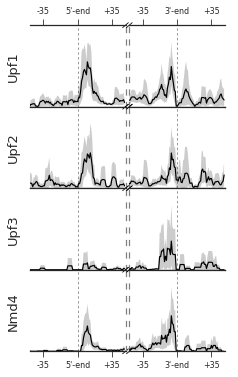

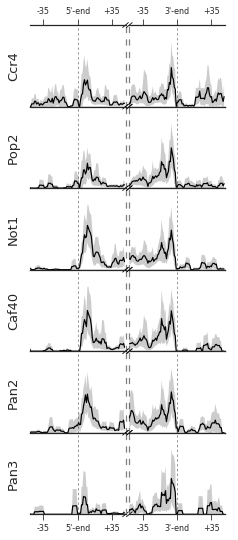

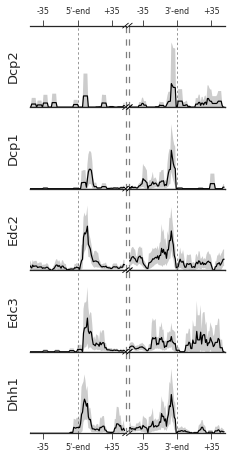

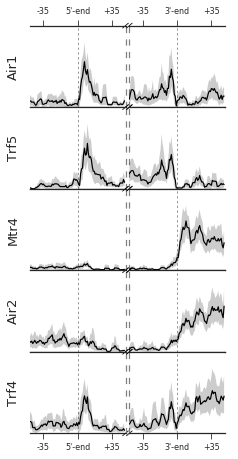

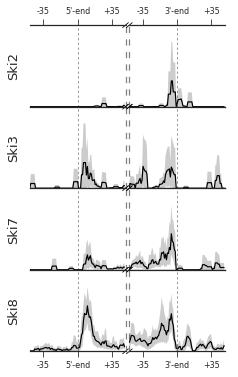

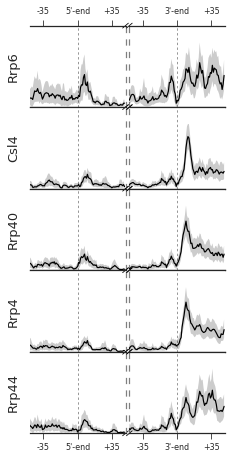

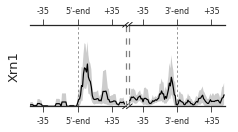

In [12]:
#marked positions on profiles based on mockinbird interval parameters 
vlinepos = [0, 100, 151, 201, 301]
labels = ['-100', '5\'-end', 'snoRNA', '3\'-end', '+100']

interval = 49
tick = 35
for pathway in pathways_of_interest:
    plot_profile_snoRNAs(pathway=pathway, col = 'black')